In [1]:
import sys
sys.path.append("/home/vateseifelfrej/thesis/l2o/")
import do_mpc
import numpy as np
import casadi as ca


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d

In [2]:
# Parameters
# obstacle
x_obs = 0.5*np.ones(3)
r_obs = 0.1
# timestep
dt = 0.1

In [ ]:
{'a':i, 'b':i+1 for i in range(2)}

In [3]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

In [4]:
# ulation time
t = model.set_variable('parameter', 't')
xi_left =   model.set_variable(var_type='_p', var_name='xi_left', shape=(3,1))
xi_right =  model.set_variable(var_type='_p', var_name='xi_right', shape=(3,1))
# ition (x, y, z)
x_left = model.set_variable(var_type='_x', var_name='x_left', shape=(3,1))
# e (z axis)
psi_left = model.set_variable(var_type='_x', var_name='psi_left', shape=(1,1))
# ocity (dx, dy, dz)
dx_left = model.set_variable(var_type='_x', var_name='dx_left', shape=(3,1))
# e velocity
dpsi_left = model.set_variable(var_type='_x', var_name='dpsi_left', shape=(1,1))
# trols (u1, u2, u3)
u_left = model.set_variable(var_type='_u', var_name='u_left', shape=(3,1))
u_psi_left = model.set_variable(var_type='_u', var_name='u_psi_left', shape=(1,1))
# ition (x, y, z)
x_right = model.set_variable(var_type='_x', var_name='x_right', shape=(3,1))
# e (z axis)
psi_right = model.set_variable(var_type='_x', var_name='psi_right', shape=(1,1))
# ocity (dx, dy, dz)
dx_right = model.set_variable(var_type='_x', var_name='dx_right', shape=(3,1))
# e velocity
dpsi_right = model.set_variable(var_type='_x', var_name='dpsi_right', shape=(1,1))
# trols (u1, u2, u3)
u_right = model.set_variable(var_type='_u', var_name='u_right', shape=(3,1))
u_psi_right = model.set_variable(var_type='_u', var_name='u_psi_right', shape=(1,1))

In [5]:
# system dynamics
model.set_rhs('x_left', x_left + dx_left * dt)
model.set_rhs('psi_left', psi_left + dpsi_left * dt)
model.set_rhs('dx_left', u_left)
model.set_rhs('dpsi_left', u_psi_left)

model.set_rhs('x_right', x_right + dx_right * dt)
model.set_rhs('psi_right', psi_right + dpsi_right * dt)
model.set_rhs('dx_right', u_right)
model.set_rhs('dpsi_right', u_psi_right)

# setup model
model.setup()

# init mpc model
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': dt,
    'store_full_solution': True,
}

mpc.set_param(**setup_mpc)
mpc.settings.supress_ipopt_output() # => verbose = False



In [6]:

# stage and terminal cost
#mterm = ca.norm_2(x_left - x_d_left) + ca.norm_2(x_right - x_d_right)
#mterm = ca.DM([[0.]])
mterm = ca.norm_2(x_left-xi_left)**2 + ca.norm_2(x_right-xi_right)**2
lterm = 0.4*mterm
# state objective
mpc.set_objective(mterm=mterm, lterm=lterm)
# input objective
mpc.set_rterm(u_left=1, u_right=1)

In [7]:
mpc.bounds['lower','_x', 'x_left'] = np.array([-3., -3., -3.0]) # stay above table
mpc.bounds['upper','_x', 'psi_left'] = np.pi/2 * np.ones((1, 1))   # rotation upper bound
mpc.bounds['lower','_x', 'psi_left'] = -np.pi/2 * np.ones((1, 1))  # rotation lower bound

mpc.bounds['lower','_x', 'x_right'] = np.array([-3., -3., -3.0]) # stay above table
mpc.bounds['upper','_x', 'psi_right'] = np.pi/2 * np.ones((1, 1))   # rotation upper bound
mpc.bounds['lower','_x', 'psi_right'] = -np.pi/2 * np.ones((1, 1))  # rotation lower bound
    # base constraints (input)
mpc.bounds['upper','_u', 'u_left'] = 0.5 * np.ones((3, 1))  # input upper bound
mpc.bounds['lower','_u', 'u_left'] = -0.5 * np.ones((3, 1))  # input lower bound
mpc.bounds['upper','_u', 'u_psi_left'] = np.pi * np.ones((1, 1))   # input upper bound
mpc.bounds['lower','_u', 'u_psi_left'] = -np.pi * np.ones((1, 1))  # input lower bound

mpc.bounds['upper','_u', 'u_right'] = 0.5 * np.ones((3, 1))  # input upper bound
mpc.bounds['lower','_u', 'u_right'] = -0.5 * np.ones((3, 1))  # input lower bound
mpc.bounds['upper','_u', 'u_psi_right'] = np.pi * np.ones((1, 1))   # input upper bound
mpc.bounds['lower','_u', 'u_psi_right'] = -np.pi * np.ones((1, 1))  # input lower bound


# collision avoidance constraint
R_left = np.array([
  [ca.cos(psi_left), -ca.sin(psi_left), 0],
  [ca.sin(psi_left), ca.cos(psi_left), 0],
  [0, 0, 1]
])
R_right = np.array([
  [ca.cos(psi_right), -ca.sin(psi_right), 0],
  [ca.sin(psi_right), ca.cos(psi_right), 0],
  [0, 0, 1]
])

#d_obs = ca.norm_2(R@(x - x_obs_p))
#mpc.set_nl_cons('d_obs', expr=-d_obs, ub=-r_obs, soft_constraint=True, penalty_term_cons=1e6)

In [8]:
# setup MPC problem
#mpc.set_uncertainty_values(t=np.array([0.])) # init time to 0

kwargs = {"t":np.array([0.]), "xi_left":[np.ones(3)], "xi_right":[-np.ones(3)]}

mpc.set_uncertainty_values(**kwargs)

mpc.setup()
# initialize MPC problem

x0 = np.zeros(16)
mpc.x0 = x0

# compute initial guess (important)
mpc.set_initial_guess()

In [9]:
# solve mpc at state x0
u0 = mpc.make_step(mpc.x0)

In [10]:
print(u0)

[[ 0.44380403]
 [ 0.44380403]
 [ 0.44380403]
 [ 0.        ]
 [-0.44380403]
 [-0.44380403]
 [-0.44380403]
 [ 0.        ]]


In [11]:
# retrieve state trajectory
x_scp_left = []
x_scp_right = []
for i in range(len(mpc.opt_x_num['_x', :, 0, 0])):
  x_scp_left.append(mpc.opt_x_num['_x', :, 0, 0][i].toarray()[:3].squeeze())
  x_scp_right.append(mpc.opt_x_num['_x', :, 0, 0][i].toarray()[8:11].squeeze())

x_scp_left = np.array(x_scp_left)
x_scp_right = np.array(x_scp_right)

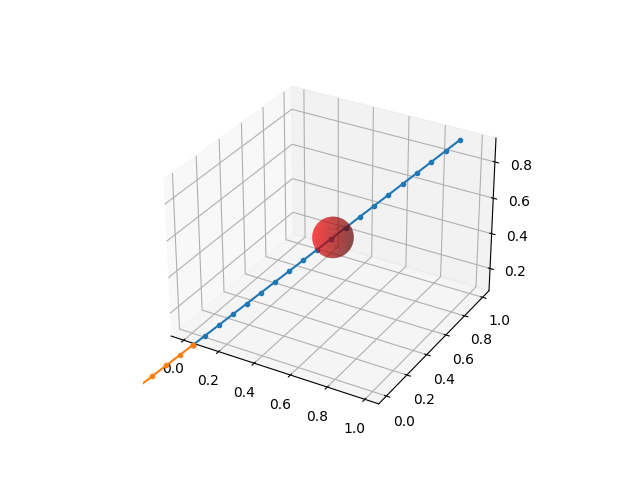

In [12]:
%matplotlib widget
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.axis('equal')
# Plot the trajectory
ax.plot(x_scp_left[:,0], x_scp_left[:,1], x_scp_left[:,2], '.-')
ax.plot(x_scp_right[:,0], x_scp_right[:,1], x_scp_right[:,2], '.-')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 50)
x_sphere = x_obs[0] + r_obs * np.outer(np.cos(u), np.sin(v))
y_sphere = x_obs[1] + r_obs * np.outer(np.sin(u), np.sin(v))
z_sphere = x_obs[2] + r_obs * np.outer(np.ones(np.size(u)), np.cos(v))
sphere = ax.plot_surface(x_sphere, y_sphere, z_sphere, color='r', alpha=0.5)
